<font color="blue">
    
# A Note on Gauss-Wishart distribution

</font>

Date: June, 2020 <br>
Author: Yuma Uchiumi <br>
Repository: https://github.com/yumaloop/BayesPredictionError

---

# Description

## Bayes rule

In Bayesian inference, we can derive the posterior distribution of model prameters $\theta$ based on observed data $x$. 

$$
(\text{posterior of } \theta) = \frac{(\text{likelihood of } x)(\text{prior of } \theta)}{Z} \\
p(\theta \vert x) = \frac{p(x \vert \theta) p(\theta)}{Z}
$$

## Gauss-Wishart distribution

When we deal with the D-dimentional data $x \in \mathbb{R}^{d}$, the Gauss-Wishart distribution can be used in Bayesian inference. 
Bayes modeling with the Gauss-Wishart distribution for D-dim data is implemented by the followings. Note that we let $\theta$ be $(\mu, \Lambda)$. Here, $\mu$ is one randam variable for the mean of $x$ and $\Lambda$ is another for the precision (= inverse covariance matrix) of $x$.

$$
p(\theta \vert x) = \frac{p(x \vert \theta) p(\theta)}{Z} \\
p(\mu, \Lambda \vert x) = \frac{p(x \vert \mu, \Lambda) p(\mu, \Lambda)}{Z} \\
p(\mu \vert \Lambda, x)p(\Lambda \vert x) = \frac{p(x \vert \mu, \Lambda) p(\mu \vert \Lambda)p(\Lambda)}{Z} 
$$

##### Likelihood

First we consider the likelihood function of $x$ as below.

$$
p(x \vert \mu, \Lambda) 
= \mathcal{N}(x \vert \mu, \Lambda^{-1}) \hspace{1em} (\text{likelihood of } x)
$$

##### Prior

Next, in order to determine the prior distribution of $(\mu, \Lambda)$, we need to set some fixed constant values to the hyperparams $(m, \beta, \nu, W)$ of our model.

$$
\begin{align}
p(\mu, \Lambda) 
&= p(\mu \vert \Lambda)p(\Lambda) \hspace{1em} (\text{prior of } \mu, \Lambda) \\
p(\mu \vert \Lambda) 
&= \mathcal{N}(\mu \vert m, \frac{1}{\beta \lambda}) \hspace{1em} (\text{prior of } \mu) \\
p(\Lambda) 
&= Gam(\lambda \vert a, b) \hspace{1em} (\text{prior of } \Lambda) 
\end{align}
$$

##### Posterior

Finally, let's derive the posterior distribution of $(\mu, \lambda)$.

$$
\begin{align}
p(\mu, \Lambda \vert x)
&= p(\mu \vert \lambda, x)p(\lambda \vert x) \hspace{1em} (\text{posterior of } \mu, \lambda) \\
p(\mu \vert \lambda, x) 
&= \mathcal{N}\left( \mu \vert \frac{\sum_{i=1}^{N} x_i + \beta m}{N+\beta}, \frac{1}{(N+\beta)\lambda} \right) \hspace{1em} (\text{posterior of } \mu) \\
p(\lambda \vert x) 
&= Gam\left(\lambda \vert a+\frac{N}{2}, b+\frac{1}{2}\left( \sum_{i=1}^{N} x_i^2 + \beta m^2 - \frac{\sum_{i=1}^{N} x_i + \beta m}{N+\beta} \right) \right) \hspace{1em} (\text{posterior of } \lambda)
\end{align}
$$

##### Predictive distributionl

...

##### Summary

The summerizing result can be written as below.

$$
\begin{align}
p(x \vert \mu, \lambda) 
&= \mathcal{N}(x \vert \mu, \lambda) \hspace{1em} (\text{likelihood of } x) \\
\\ \\
p(\mu, \lambda) 
&= p(\mu \vert \lambda)p(\lambda) \hspace{1em} (\text{prior of } \mu, \lambda) \\
p(\mu \vert \lambda) 
&= \mathcal{N}(\mu \vert m, \frac{1}{\beta \lambda}) \hspace{1em} (\text{prior of } \mu) \\
p(\lambda) 
&= Gam(\lambda \vert a, b) \hspace{1em} (\text{prior of } \lambda) \\
\\ \\
p(\mu, \lambda \vert x)
&= p(\mu \vert \lambda, x)p(\lambda \vert x) \hspace{1em} (\text{posterior of } \mu, \lambda) \\
p(\mu \vert \lambda, x) 
&= \mathcal{N}\left( \mu \vert \frac{\sum_{i=1}^{N} x_i + \beta m}{N+\beta}, \frac{1}{(N+\beta)\lambda} \right) \hspace{1em} (\text{posterior of } \mu) \\
p(\lambda \vert x) 
&= Gam\left(\lambda \vert a+\frac{N}{2}, b+\frac{1}{2}\left( \sum_{i=1}^{N} x_i^2 + \beta m^2 - \frac{\sum_{i=1}^{N} x_i + \beta m}{N+\beta} \right) \right) \hspace{1em} (\text{posterior of } \lambda)
\end{align}
$$

# Code

In [62]:
import os
import sys

import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline

In [63]:
import numpy as np
from scipy import stats


class Prior():
    """ N-dim Gaussian-Wishart distribution """
    def __init__(self, m=0.0, beta=1, nu=None, W=None):
        """
        (x, A) ~ NW(m, beta, W, nu) = N(x | m, (beta A)^-1 ) W(A | W, nu)
        """
        self.m = m
        self.beta = beta
        self.nu = nu # degree of freedom for Wishart dist.
        self.W = W
        
    def pdf(self, x, S):
        """ Probability Density Function """
        A = np.linalg.inv(S)
        pdf = stats.multivariate_normal.pdf(x, mean=self.m, cov=np.linalg.inv(self.beta * A))
        pdf = pdf * stats.wishart.pdf(A, df=self.nu, scale=self.W)
        return pdf
    
    def rvs(self, size=100):
        """ Random Variates """
        A = stats.wishart.rvs(df=self.nu, scale=self.W, size=size)
        x = stats.norm.rvs(mean=self.m, cov=np.linalg.inv(self.beta * A))
        return x, A
        

class PosteriorMean():
    """ N-dim Gaussian distribution """
    def __init__(self, data=None, m=None, beta=None, A=None):
        self.N = len(data)
        self.beta_hat = beta + self.N
        self.m_hat = (np.sum(data) + beta * m) / (self.beta_hat)
        self.A = A
        
        self.mean = self.m_hat
        self.cov = np.linalg.inv(self.beta_hat * self.A)
        
    def pdf(self, x):
        """ Probability Density Function """
        return stats.multivariate_norm.pdf(x, mean=self.mean, cov=self.cov)
    
    def rvs(self, size=100):
        """ Random Variates """
        return stats.multivariate_norm.rvs(mean=self.mean, cov=self.cov, size=size)


class PosteriorPrecision():
    """ N-dim Wishart distribution """
    def __init__(self, data=None, beta=None, beta_hat=None, nu=None, m=None, m_hat=None, W=None):
        self.N = len(data) # num
        self.dim = data.shape[1] # dim
        self.beta = beta
        self.beta_hat = beta_hat
        self.nu = nu
        self.m = m
        self.m_hat = m
        self.W = W

        # W_hat
        X = np.zeros((self.dim, self.dim))
        for x in data:
            X = X + np.outer(x, x)
        W_hat_inv = X + beta * np.outer(m, m) - beta_hat * np.outer(m_hat, m_hat) + np.linalg.inv(W)
        self.W_hat = np.linalg.inv(W_hat_inv)
        # nu_hat
        self.nu_hat = self.nu + self.N
        
    def pdf(self, x):
        """ Probability Density Function """
        return stats.wishart.pdf(x, df=self.nu_hat, scale=self.W_hat)
    
    def mean(self):
        return self.nu_hat * self.W_hat
    
    def rvs(self, size=100):
        """ Random Variates """
        return stats.wishart.rvs(df=self.nu_hat, scale=self.W_hat, size=size)

    
class Likelihood():
    """ N-dim Gaussian distribution """
    def __init__(self, mu=0.0, A=None):
        self.mu = mu
        self.A = A

        self.mean = mu
        self.cov = np.linalg.inv(A)
        
    def pdf(self, x):
        """ Probability Density Function """
        return stats.multivariate_norm.pdf(x, mean=self.mean, cov=self.cov)
    
    def logpdf(self, x):
        """ Log Probability Density Function """
        return stats.multivariate_norm.logpdf(x, mean=self.mean, cov=self.cov)
    
    def rvs(self, size=100):
        """ Random Variates """
        return stats.multivariate_norm.rvs(x, mean=self.mean, cov=self.cov, size=size)


class PredDist():
    """ N-dim Student's t-distribution """
    def __init__(self, dim=None, m=None, beta=None, W=None, nu=None):
        self.dim = dim
        self.m = m
        self.beta = beta
        self.W = W
        self.nu = nu

        self.df = 1 - dim + nu # degree of freedom
        self.loc = m
        self.scale = W * (self.df * beta) / (1 + beta)
        self.mean = m
        
    def pdf(self, x):
        """ Probability Density Function """
        return stats.t.pdf(x, self.df, self.loc, self.scale)
    
    def cdf(self, x):
        """ survival function """
        return stats.t.cdf(x, self.df, self.loc, self.scale)
    
    def logpdf(self, x):
        """ Log Probability Density Function """
        return stats.t.logpdf(x, self.df, self.loc, self.scale)
    
    def sf(self, x):
        return stats.t.sf(x, self.df, self.loc, self.scale)
    
    def error(self, x):
        return abs(x - self.mean)
    
    def rvs(self, size=100):
        """ Random Variates """
        return stats.t.rvs(self.df, self.loc, self.scale, size=size)

In [66]:
class TrueDist():
    def __init__(self, mean=0.0, cov=None):
        self.mean = mean
        self.cov = cov
        
    def pdf(self, x):
        return stats.multivariate_normal.pdf(x, mean=self.mean, cov=self.cov)
    
    def rvs(self, size=100):
        return stats.multivariate_normal.rvs(x, mean=self.mean, cov=self.cov, size=size)

# Visualization: figure assets

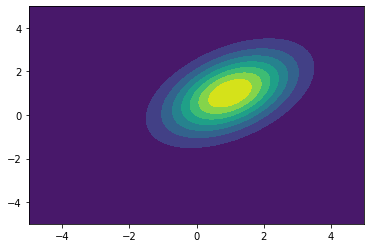

In [76]:
# True distribution
mean = [1.0, 1.0]
cov = [[1.5, 0.7], [0.7, 1.5]]

x1, x2 = np.mgrid[-5:5:.01, -5:5:.01]
sx = np.dstack((x1, x2)) # sx: (1000, 1000, 2)
sy = [TrueDist(mean, cov).pdf(x) for x in sx]

fig = plt.figure()
ax = fig.add_subplot(111)
ax.contourf(x1, x2, sy)

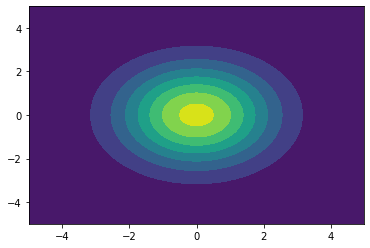

In [74]:
# Prior of mean

dim = 2
nu = 10 # df

beta = 1.0
m = [0.0, 0.0]
W = [[2.5, 0.0], [0.0, 2.5]]
S = W

x1, x2 = np.mgrid[-5:5:.01, -5:5:.01]
sx = np.dstack((x1, x2)) # sx: (1000, 1000, 2)
sy = [Prior(m=m, beta=beta, nu=nu, W=W).pdf(x, S) for x in sx]

fig = plt.figure()
ax = fig.add_subplot(111)
ax.contourf(x1, x2, sy)

In [ ]:
# Likelihood
mu = 0.0
lam = 1.0
sx = np.arange(-5,5,0.01)
sy = [Likelihood(mu=mu, lam=lam).pdf(x) for x in sx]
plt.fill_between(sx, sy, label="likelihood", alpha=0.25, facecolor="orange")

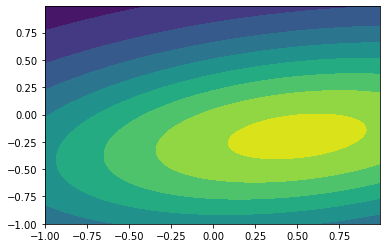

In [33]:
x, y = np.mgrid[-1:1:.01, -1:1:.01]
pos = np.dstack((x, y))

mean = [0.5, -0.2]
cov = [[2.0, 0.3], [0.3, 0.5]]
rv = stats.multivariate_normal(mean, cov)

fig2 = plt.figure()
ax2 = fig2.add_subplot(111)
ax2.contourf(x, y, rv.pdf(pos))

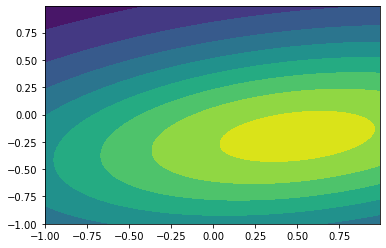

In [38]:
x, y = np.mgrid[-1:1:.01, -1:1:.01]
pos = np.dstack((x, y))

m = [0.5, -0.2]
W = [[2.0, 0.3], [0.3, 0.5]]

rv = Prior(m=m, beta=1.0, nu=10, W=W)

fig2 = plt.figure()
ax2 = fig2.add_subplot(111)
ax2.contourf(x, y, rv.pdf(pos, W))

# Animation 1

only predictive distribution

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/site-packages/matplotlib/cbook/__init__.py", line 216, in process
    func(*args, **kwargs)
  File "/usr/local/lib/python3.7/site-packages/matplotlib/animation.py", line 1465, in _stop
    self.event_source.remove_callback(self._loop_delay)
AttributeError: 'NoneType' object has no attribute 'remove_callback'


<IPython.core.display.Javascript object>


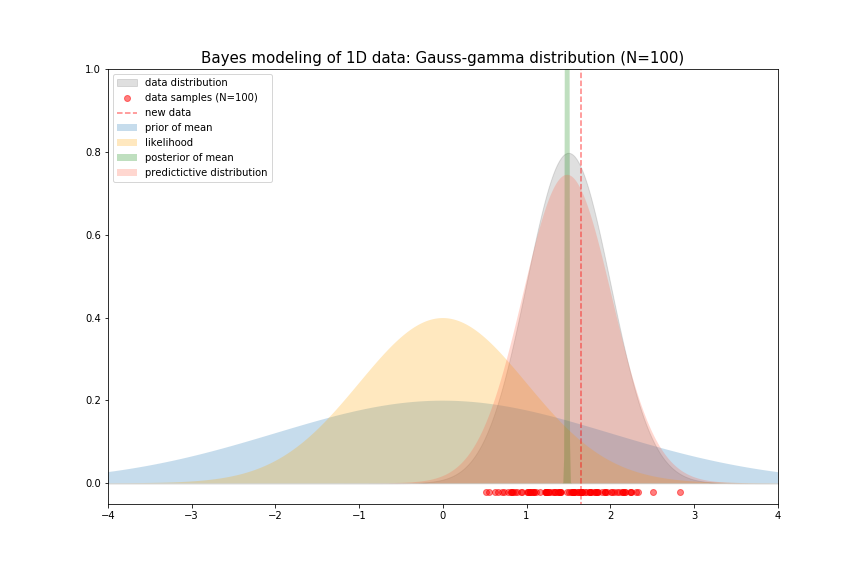

In [39]:
import matplotlib.pyplot as plt
from matplotlib import animation
%matplotlib nbagg

def update(i, all_data):
    plt.cla()    
    data = all_data[:i]
    
    # True distribution
    mean = 1.5
    precision = 2
    sx = np.arange(-5,5,0.01)
    sy = [TrueDist(mean, precision).pdf(x) for x in sx]
    plt.fill_between(sx, sy, label="data distribution", color="gray", alpha=0.25)

    # ###  Data sample
    plt.scatter(data, np.zeros(len(data))-0.02, alpha=0.5, color="red", marker="o", label="data samples (N={})".format(len(data)))    
    plt.vlines(x=data[-1], ymin=-1, ymax=1, alpha=0.5, color="red", linestyles="dashed", label="new data")

    # Prior of mean
    m = 0.
    lam = 0.5
    beta = 1.
    sx = np.arange(-5,5,0.01)
    sy = [PriorMean(m=m, lam=lam, beta=beta).pdf(x) for x in sx]
    plt.fill_between(sx, sy, label="prior of mean", alpha=0.25)

    # Prior of precision
    a = 2
    b = 2

    # Likelihood
    mu = 0.0
    lam = 1.0
    sx = np.arange(-5,5,0.01)
    sy = [Likelihood(mu=mu, lam=lam).pdf(x) for x in sx]
    plt.fill_between(sx, sy, label="likelihood", alpha=0.25, facecolor="orange")

    # Posterior of mean
    sx = np.arange(-5,5,0.01)
    sy = [PosteriorMean(data=data, m=m, lam=lam, beta=beta).pdf(x) for x in sx]
    plt.fill_between(sx, sy, label="posterior of mean", alpha=0.25, facecolor="green")

    # Posterior of precision

    # Predictive distribution
    m_hat = PosteriorMean(data=data, m=m, lam=lam, beta=beta).m_hat
    beta_hat = PosteriorMean(data=data, m=m, lam=lam, beta=beta).beta_hat
    a_hat = PosteriorPrecision(data=data, a=a, b=b, beta=beta, m=m).a_hat
    b_hat = PosteriorPrecision(data=data, a=b, b=b, beta=beta, m=m).b_hat

    sx = np.arange(-5,5,0.01)
    sy = [PredDist(m=m_hat, beta=beta_hat, a=a_hat, b=b_hat).pdf(x) for x in sx]
    plt.fill_between(sx, sy, label="predictictive distribution", facecolor="tomato", alpha=0.25)

    plt.ylim([-0.05, 1])
    plt.xlim([-4, 4])
    plt.legend(loc="upper left")
    plt.title("Bayes modeling of 1D data: Gauss-gamma distribution (N={})".format(len(data)), fontsize=15)
    
# Data sample
N = 100
mean = 1.5
precision = 2
all_data = TrueDist(mean, precision).rvs(size=N)
fig = plt.figure(figsize = (12,8))

params = {
    'fig': fig, # fig object (defined by matplotlib)
    'func': update, # update function to reproduce figures
    'fargs': (all_data,), # arguments of `func`
    'interval': 300, # interval time (ms)
    'frames': np.arange(1, N+1, 1), # frame size
    'repeat': False, # Flag for repeat play
    'blit': False # Flag for blitting
}

# Create animation
ani = animation.FuncAnimation(**params)

# Save animation
# ani.save('bayes_demo.gif', writer="imagemagick")
# ani.save('bayes_demo.mp4', writer="ffmpeg")

# Show animation
plt.show()

# Animation 2

predictive distribution & surprise

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/site-packages/matplotlib/cbook/__init__.py", line 216, in process
    func(*args, **kwargs)
  File "/usr/local/lib/python3.7/site-packages/matplotlib/animation.py", line 1465, in _stop
    self.event_source.remove_callback(self._loop_delay)
AttributeError: 'NoneType' object has no attribute 'remove_callback'


<IPython.core.display.Javascript object>


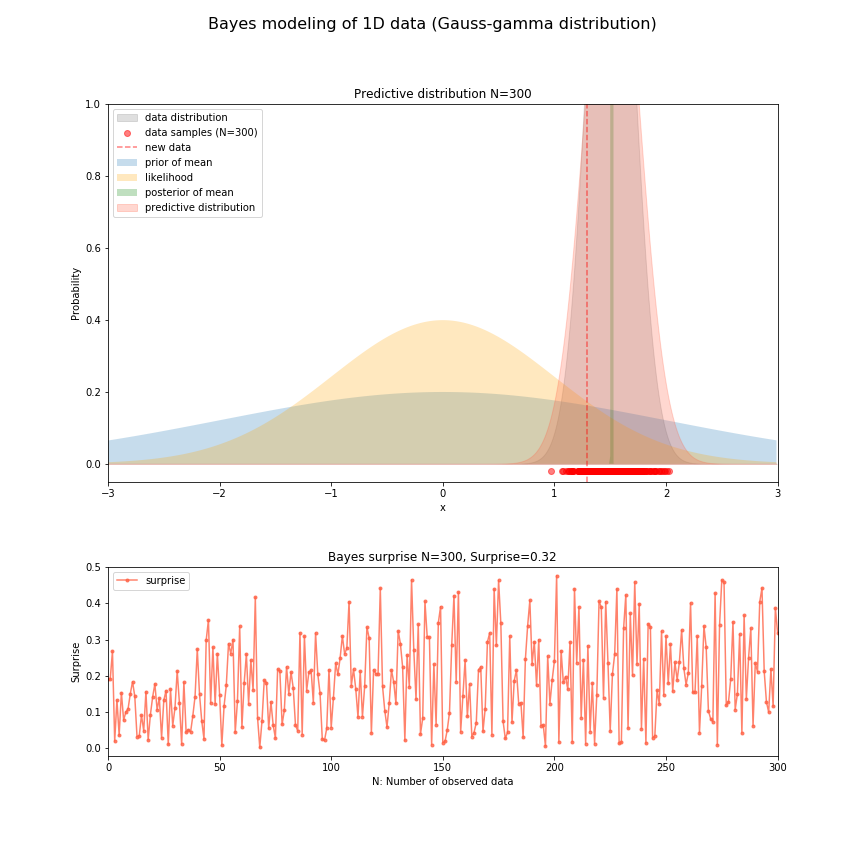

In [38]:
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib import gridspec
%matplotlib nbagg


def update(i, all_data):    
    plt.cla()
    ax1.cla()   
    ax2.cla()
    
    data = all_data[:i]
    sx = np.arange(-3,3,0.01)
        
    # True distribution
    mean = 1.5
    precision = 5
    sy = [TrueDist(mean, precision).pdf(x) for x in sx]
    ax1.fill_between(sx, sy, label="data distribution", color="gray", alpha=0.25)
    
    ##  Data sample
    ax1.scatter(data, np.zeros(len(data))-0.02, alpha=0.5, color="red", marker="o", label="data samples (N={})".format(len(data)))        
    ax1.vlines(x=data[-1], ymin=-1, ymax=1, alpha=0.5, color="red", linestyles="dashed", label="new data")
    
    # Prior of mean
    m = 0.
    lam = 0.5
    beta = 1.
    sy = [PriorMean(m=m, lam=lam, beta=beta).pdf(x) for x in sx]
    ax1.fill_between(sx, sy, label="prior of mean", alpha=0.25)
    
    # Prior of precision
    a = 2
    b = 2

    # Likelihood
    mu = 0.0
    lam = 1.0
    sy = [Likelihood(mu=mu, lam=lam).pdf(x) for x in sx]
    ax1.fill_between(sx, sy, label="likelihood", alpha=0.25, facecolor="orange")
    
    # Posterior of mean
    sy = [PosteriorMean(data=data, m=m, lam=lam, beta=beta).pdf(x) for x in sx]
    ax1.fill_between(sx, sy, label="posterior of mean", alpha=0.25, facecolor="green")

    # Prediction 
    m_hat=PosteriorMean(data=data, m=m, lam=lam, beta=beta).m_hat
    beta_hat=PosteriorMean(data=data, m=m, lam=lam, beta=beta).beta_hat
    a_hat=PosteriorPrecision(data=data, a=a, b=b, beta=beta, m=m).a_hat
    b_hat=PosteriorPrecision(data=data, a=b, b=b, beta=beta, m=m).b_hat

    sy = [PredDist(m=m_hat, beta=beta_hat, a=a_hat, b=b_hat).pdf(x) for x in sx]
    ax1.fill_between(sx, sy, label="predictive distribution", alpha=0.25, color="tomato")
    
    sp_x = PredDist(m=m_hat, beta=beta_hat, a=a_hat, b=b_hat).surprise(data[-1])
    surprises.append(sp_x)
    sx = np.arange(len(surprises))
    sy = surprises
    ax2.plot(sx, sy, label="surprise", marker=".", color="tomato", alpha=0.8)
    
    # view settings
    ax1.legend(loc="upper left")
    ax1.set_ylim([-0.05,1])
    ax1.set_xlim([-3,3])
    ax1.set_xlabel("x")
    ax1.set_ylabel("Probability")
    ax1.set_title("Predictive distribution N={}".format(len(data)), fontsize=12)
    
    ax2.legend()
    ax2.set_xlim([0,len(data)])
    ax2.set_xlabel("N: Number of observed data")
    ax2.set_ylabel("Surprise")
    ax2.set_title("Bayes surprise N={}, Surprise={:.2f}".format(len(data), sp_x), fontsize=12)
    

# Data sample
N = 300
mean = 1.5
precision = 5
all_data = TrueDist(mean, precision).rvs(size=N)
surprises = []

# Figure settings
fig = plt.figure(figsize = (12,12))
fig.suptitle("Bayes modeling of 1D data (Gauss-gamma distribution)", fontsize=16)

spec = gridspec.GridSpec(ncols=1, nrows=2, height_ratios=[2, 1])
ax1 = fig.add_subplot(spec[0])
ax2 = fig.add_subplot(spec[1])
fig.subplots_adjust(hspace=0.3)

params = {
    'fig': fig, # fig object (defined by matplotlib)
    'func': update, # update function to reproduce figures
    'fargs': (all_data,), # arguments of `func`
    'interval': 300, # interval time (ms)
    'frames': np.arange(1, N+1, 1), # frame size
    'repeat': False, # Flag for repeat play
    'blit': False # Flag for blitting
}

# Create animation
ani = animation.FuncAnimation(**params)

# Save animation
# ani.save('bayes_surprise_demo.gif', writer="imagemagick")
# ani.save('bayes_surprise_demo.mp4', writer="ffmpeg")

# Show animation
plt.show()

# Animation2

predictive dist & surprise & errorm

<IPython.core.display.Javascript object>


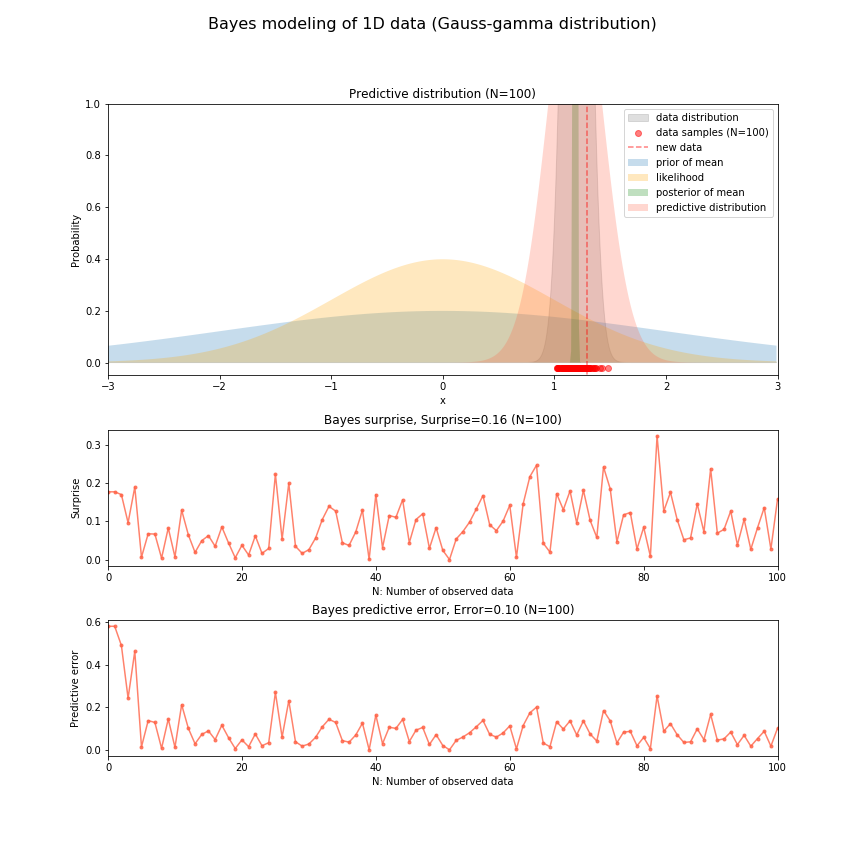

In [17]:
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib import gridspec
%matplotlib nbagg


def update(i, all_data):
    data = all_data[:i]
    
    plt.cla()
    ax1.cla()   
    ax2.cla()
    ax3.cla()
    
    ax1.set_ylim([-0.05,1])
    ax1.set_xlim([-3,3])  
    sx = np.arange(-3,3,0.01)
    
    ax2.set_xlim([0,len(data)])
    ax3.set_xlim([0,len(data)])
    
    # True distribution
    mean = 1.2
    precision = 10
    sy = [TrueDist(mean, precision).pdf(x) for x in sx]
    ax1.fill_between(sx, sy, label="data distribution", color="gray", alpha=0.25)
        
    ##  Data sample
    ax1.scatter(data, np.zeros(len(data))-0.02, alpha=0.5, color="red", marker="o", label="data samples (N={})".format(len(data)))    
    ax1.vlines(x=data[-1], ymin=-1, ymax=1, alpha=0.5, color="red", linestyles="dashed", label="new data")
    
    # Prior of mean
    m = 0.
    lam = 0.5
    beta = 1.
    sy = [PriorMean(m=m, lam=lam, beta=beta).pdf(x) for x in sx]
    ax1.fill_between(sx, sy, label="prior of mean", alpha=0.25)
    
    # Prior of precision
    a = 2
    b = 2

    # Likelihood
    mu = 0.0
    lam = 1.0
    sy = [Likelihood(mu=mu, lam=lam).pdf(x) for x in sx]
    ax1.fill_between(sx, sy, label="likelihood", alpha=0.25, facecolor="orange")
    
    # Posterior of mean
    sy = [PosteriorMean(data=data, m=m, lam=lam, beta=beta).pdf(x) for x in sx]
    ax1.fill_between(sx, sy, label="posterior of mean", alpha=0.25, facecolor="green")

    # Predictive distribution
    m_hat=PosteriorMean(data=data, m=m, lam=lam, beta=beta).m_hat
    beta_hat=PosteriorMean(data=data, m=m, lam=lam, beta=beta).beta_hat
    a_hat=PosteriorPrecision(data=data, a=a, b=b, beta=beta, m=m).a_hat
    b_hat=PosteriorPrecision(data=data, a=b, b=b, beta=beta, m=m).b_hat

    sy = [PredDist(m=m_hat, beta=beta_hat, a=a_hat, b=b_hat).pdf(x) for x in sx]
    ax1.fill_between(sx, sy, label="predictive distribution", alpha=0.25, facecolor="tomato")
    
    # Surprise based on the predictive distribution
    sp_x = PredDist(m=m_hat, beta=beta_hat, a=a_hat, b=b_hat).surprise(data[-1])
    surprises.append(sp_x)
    sx = np.arange(len(surprises))
    sy = surprises
    ax2.plot(sx, sy, label="surprise", marker=".", color="tomato", alpha=0.8)
    
    # Error based on the predictive distribution
    err_x = PredDist(m=m_hat, beta=beta_hat, a=a_hat, b=b_hat).error(data[-1])
    errors.append(err_x)
    sx = np.arange(len(errors))
    sy = errors
    ax3.plot(sx, sy, label="predictive error", marker=".", color="tomato", alpha=0.8)
    
    
    ax1.legend()
    ax1.set_xlabel("x")
    ax1.set_ylabel("Probability")
    ax1.set_title("Predictive distribution (N={})".format(len(data)), fontsize=12)
    
    ax2.set_xlabel("N: Number of observed data")
    ax2.set_ylabel("Surprise")
    ax2.set_title("Bayes surprise, Surprise={:.2f} (N={})".format(sp_x, len(data)), fontsize=12)
    
    ax3.set_xlabel("N: Number of observed data")
    ax3.set_ylabel("Predictive error")
    ax3.set_title("Bayes predictive error, Error={:.2f} (N={})".format(err_x, len(data)), fontsize=12)
    

# Data sample
N = 500
mean = 1.2
precision = 10
data = [TrueDist(mean, precision).rvs(size=N)]
surprises = []
errors = []

# Figure settgins
fig = plt.figure(figsize = (12,12))
fig.suptitle("Bayes modeling of 1D data (Gauss-gamma distribution)", fontsize=16)

spec = gridspec.GridSpec(ncols=1, nrows=3, height_ratios=[2, 1, 1])
ax1 = fig.add_subplot(spec[0])
ax2 = fig.add_subplot(spec[1])
ax3 = fig.add_subplot(spec[2])
fig.subplots_adjust(hspace=0.3)

params = {
    'fig': fig, # fig object (defined by matplotlib)
    'func': update, # update function to reproduce figures
    'fargs': (all_data,), # arguments of `func`
    'interval': 100, # interval time (ms)
    'frames': np.arange(1, N+1, 1), # frame size
    'repeat': False, # Flag for repeat play
    'blit': False # Flag for blitting
}

# Create animation
ani = animation.FuncAnimation(**params)

# Save animation
# ani.save('bayes_surprise_error.gif', writer="imagemagick")
# ani.save('bayes_surprise_error.mp4', writer="ffmpeg")

# Show animation
plt.show()

# Animation3: 

<IPython.core.display.Javascript object>


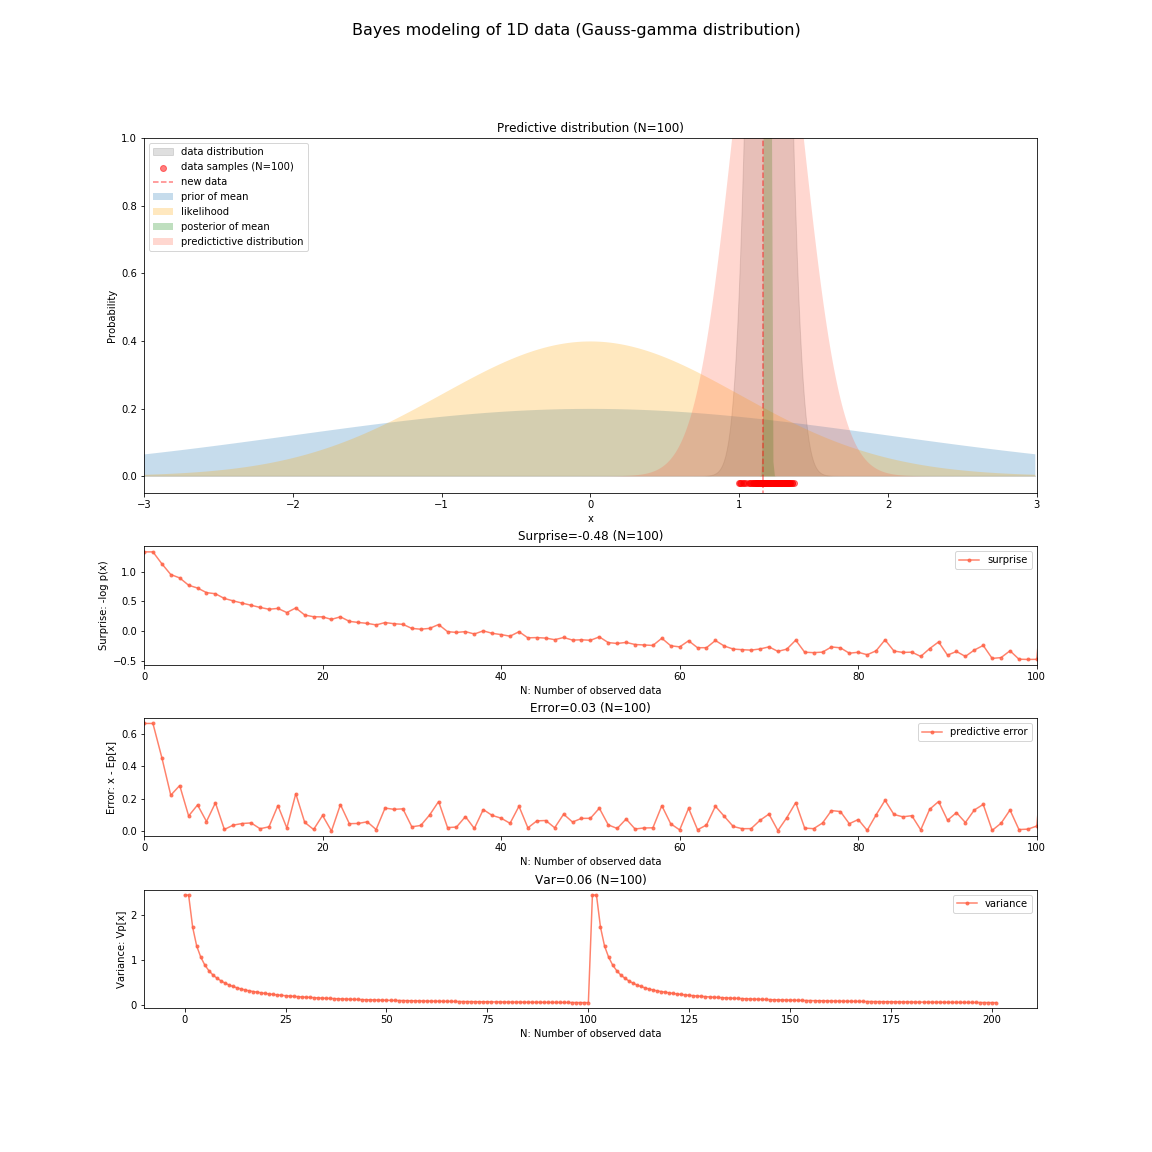

In [28]:
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib import gridspec
%matplotlib nbagg


def update(i, all_data):    
    plt.cla()
    ax1.cla()   
    ax2.cla()
    ax3.cla()
    ax4.cla()
        
    sx = np.arange(-3,3,0.01)
    data = all_data[:i]
    
    # True distribution
    mean = 1.2
    precision = 10
    sy = [TrueDist(mean, precision).pdf(x) for x in sx]
    ax1.fill_between(sx, sy, label="data distribution", color="gray", alpha=0.25)
        
    ##  Data sample
    ax1.scatter(data, np.zeros(len(data))-0.02, alpha=0.5, color="red", marker="o", label="data samples (N={})".format(len(data)))    
    ax1.vlines(x=data[-1], ymin=-1, ymax=1, alpha=0.5, color="red", linestyles="dashed", label="new data")
    
    # Prior of mean
    m = 0.
    lam = 0.5
    beta = 1.
    sy = [PriorMean(m=m, lam=lam, beta=beta).pdf(x) for x in sx]
    ax1.fill_between(sx, sy, label="prior of mean", alpha=0.25)
    
    # Prior of precision
    a = 2
    b = 2

    # Likelihood
    mu = 0.0
    lam = 1.0
    sy = [Likelihood(mu=mu, lam=lam).pdf(x) for x in sx]
    ax1.fill_between(sx, sy, label="likelihood", alpha=0.25, facecolor="orange")
    
    
    # Posterior of mean
    sy = [PosteriorMean(data=data, m=m, lam=lam, beta=beta).pdf(x) for x in sx]
    ax1.fill_between(sx, sy, label="posterior of mean", alpha=0.25, facecolor="green")
    
    # Posterior of precision

    # Predictive distribution
    m_hat = PosteriorMean(data=data, m=m, lam=lam, beta=beta).m_hat
    beta_hat = PosteriorMean(data=data, m=m, lam=lam, beta=beta).beta_hat
    a_hat = PosteriorPrecision(data=data, a=a, b=b, beta=beta, m=m).a_hat
    b_hat = PosteriorPrecision(data=data, a=b, b=b, beta=beta, m=m).b_hat

    sy = [PredDist(m=m_hat, beta=beta_hat, a=a_hat, b=b_hat).pdf(x) for x in sx]
    ax1.fill_between(sx, sy, label="predictictive distribution", facecolor="tomato", alpha=0.25)
    
    # Surprise based on the predictive distribution
    sp_x = -1 * PredDist(m=m_hat, beta=beta_hat, a=a_hat, b=b_hat).logpdf(data[-1])
    surprises.append(sp_x)
    sx = np.arange(len(surprises))
    sy = surprises
    ax2.plot(sx, sy, label="surprise", marker=".", color="tomato", alpha=0.8)
    
    # Error based on the predictive distribution
    err_x = PredDist(m=m_hat, beta=beta_hat, a=a_hat, b=b_hat).error(data[-1])
    errors.append(err_x)
    sx = np.arange(len(errors))
    sy = errors
    ax3.plot(sx, sy, label="predictive error", marker=".", color="tomato", alpha=0.8)
    
    # Var of the predictive distribution
    var_x = PredDist(m=m_hat, beta=beta_hat, a=a_hat, b=b_hat).var
    variances.append(var_x)
    sx = np.arange(len(variances))
    sy = variances
    ax4.plot(sx, sy, label="variance", marker=".", color="tomato", alpha=0.8)
    
    # View settings
    ax1.legend(loc="upper left")
    ax1.set_ylim([-0.05,1])
    ax1.set_xlim([-3,3]) 
    ax1.set_xlabel("x")
    ax1.set_ylabel("Probability")
    ax1.set_title("Predictive distribution (N={})".format(len(data)), fontsize=12)
    
    ax2.legend()
    ax2.set_xlim([0,len(data)])
    ax2.set_xlabel("N: Number of observed data")
    ax2.set_ylabel("Surprise: -log p(x)")
    ax2.set_title("Surprise={:.2f} (N={})".format(sp_x, len(data)), fontsize=12)
    
    ax3.legend()
    ax3.set_xlim([0,len(data)])
    ax3.set_xlabel("N: Number of observed data")
    ax3.set_ylabel("Error: x - Ep[x]")
    ax3.set_title("Error={:.2f} (N={})".format(err_x, len(data)), fontsize=12)
    
    ax4.legend()
    ax4.set_xlabel("N: Number of observed data")
    ax4.set_ylabel("Variance: Vp[x]")
    ax4.set_title("Var={:.2f} (N={})".format(var_x, len(data)), fontsize=12)

# Data sample
N = 100
mean = 1.2
precision = 10
all_data = TrueDist(mean, precision).rvs(size=N)
surprises = []
errors = []
variances = []

# Figure settgins
fig = plt.figure(figsize = (16,16))
fig.suptitle("Bayes modeling of 1D data (Gauss-gamma distribution)", fontsize=16)

spec = gridspec.GridSpec(ncols=1, nrows=4, height_ratios=[3, 1, 1, 1])
ax1 = fig.add_subplot(spec[0])
ax2 = fig.add_subplot(spec[1])
ax3 = fig.add_subplot(spec[2])
ax4 = fig.add_subplot(spec[3])
fig.subplots_adjust(hspace=0.3)

params = {
    'fig': fig, # fig object (defined by matplotlib)
    'func': update, # update function to reproduce figures
    'fargs': (all_data,), # arguments of `func`
    'interval': 300, # interval time (ms)
    'frames': np.arange(1, N+1, 1), # frame size
    'repeat': False, # Flag for repeat play
    'blit': False # Flag for blitting
}

# Create animation
ani = animation.FuncAnimation(**params)

# Save animation
# ani.save('hogehoge.gif', writer="imagemagick")
ani.save('hogehoge.mp4', writer="ffmpeg")

# Show animation
# plt.show()

In [18]:
def prior_mean(x, m=0.0, lam=1, beta=1):    
    return stats.norm.pdf(x, loc=m, scale=1/(beta*lam))

def prior_precision(x, a=2, b=2):
    return scipy.stats.gamma.pdf(x, a, loc=0, scale=b)


def posterior_mean(x, data=None, m=None, lam=None, beta=None):
    N = len(data)
    m_hat = (np.sum(data) + beta * m) / (beta + N)
    beta_hat = beta + N
    return stats.norm.pdf(x, loc=m_hat, scale=1/(beta_hat*lam))


def posterior_precision(x, data=None, a=None, b=None):
    N = len(data)
    a_hat = a + N / 2
    b_hat = b + 0.5 * (np.sum(data ** 2) + beta * (m ** 2) - (1/(beta + N)) * (np.sum(data ** 2) + beta * m) ** 2)
    return stats.gamma.pdf(x, a_hat, loc=0, scale=b_hat)


def likelihood(x, mu=0.0, lam=1.0):
    return stats.norm.pdf(x, loc=mu, scale=1/lam)


def pred_dist(x, m=None, beta=None, a=None, b=None):
    df = 2 * a # degree of freedom
    loc = m
    scale = (beta/(beta + 1)) * (a/b)
    return stats.t.pdf(x, df, loc, scale)


In [3]:
def true_dist(x):
    return stats.norm.pdf(x, loc=0.01, scale=1.4)

In [4]:
N = 50
data = stats.norm.rvs(loc=0.01, scale=1.4, size=N)
data.shape

(50,)

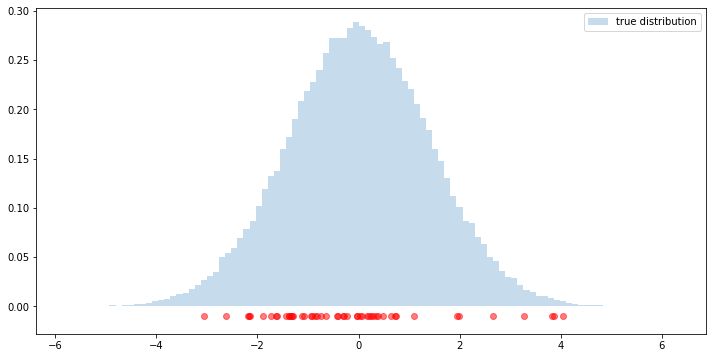

In [5]:
s = stats.norm.rvs(loc=0.01, scale=1.4, size=100000)

plt.figure(figsize=(12,6))
plt.hist(s, bins=100, density=True, alpha=0.25, label="true distribution")
plt.scatter(data, np.zeros(len(data))-0.01, alpha=0.5, c="r")
plt.legend()
plt.show()

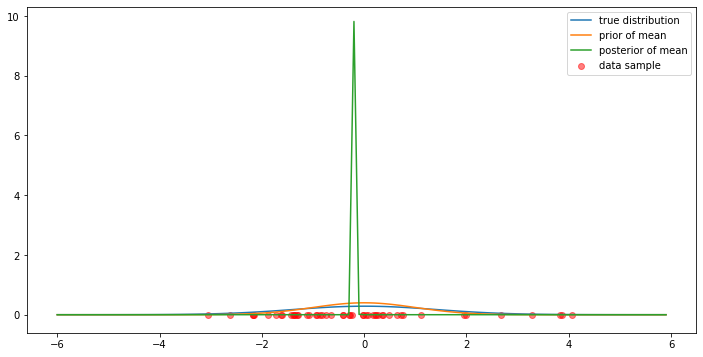

In [19]:
plt.figure(figsize=(12,6))

# True distribution
sx = np.arange(-6, 6, 0.1)
sy = [true_dist(sxi) for sxi in sx]
plt.plot(sx, sy, label="true distribution")

# Prior of mean
m=0.
lam=1.
beta=1.
sy = [prior_mean(sxi, m=m, lam=lam, beta=beta) for sxi in sx]
plt.plot(sx, sy, label="prior of mean")

# Prior of lambda


# Posterior of mean

sy = [posterior_mean(sxi, data=data, m=m, lam=lam, beta=beta) for sxi in sx]
plt.plot(sx, sy, label="posterior of mean")

# Data sample
plt.scatter(data, np.zeros(len(data))-0.01, alpha=0.5, c="r", label="data sample")

plt.legend()
plt.show()